# Supplementary Material to:
# Blueprint for Next Generation Cyber-Physical Resilience using Defense Quantum Machine - Learning Two-train Example
# Authors

Michel Barbeau

Joaquin Garcia-Alfaro

Version: September 12, 2021

We reused code from: 
<a href="https://pennylane.ai/qml/demos/tutorial_qubit_rotation.html">Basic tutorial: qubit rotation</a>
   
Note: This example runs of version 0.8.0 of Pennylane, which is not the *defaul latest version*. To force installation of that version, in a Linux shell enter:

python -m pip install pennylane==0.8.0

## Two-train scenario

Let us consider the following discrete two-train scenario:

   ![track](two_train.png)

Tracks are broken into sections.
Let us assume a scenario where Train 1 is the agent and Train 2 is part of its world.
There is an outer loop visiting points 3, 4 and 5,
together with a bypass from point 2, visiting point 8 to point 6.
Traversal time is uniform across sections.
The normal trajectory of Train 1 is the outer loop,
while maintaining a Train 2-Train 1 distance greater than one empty section.
For example, if Train 1 is at point 0 while
Train 2 is at point 7, then
the separation distance constraint is violated.
The goal of the adversary is to steer the system in a state where the separation distance constraint is violated.
When a train crosses point 0,
it has to make a choice: either traverse the outer loop or take the bypass.
Both trains can follow any path and make independent choices, 
when they are at point 0.

In the terms of reinforcement learning,
Train 1 has two actions available: take loop and take bypass.
The agent gets $k$ reward points for a relative Train 2-Train 1 distance increase of $k$ sections with Train 2.
It gets $-k$ reward points, i.e., a penalty, 
for a relative Train 2-Train 1 distance decrease of $k$ sections with Train 2.
For example, let us assume that Train 1 is at point 0 and that Train 2 is at point 7.
If both trains, progressing a the same speed, take the loop or both  decide to take the bypass,
then there is no relative distance change.
The agent gets no reward.
When Train 1 decides to take the bypass and Train 2 decides to take the loop,
the agent gets two reward points,
at return to point zero (Train 2 is at point five).
When Train 1 decides to take the loop and Train 2 decides to take the bypass,
the agent gets four reward points,
at return to point zero (Train 2 is at point one, Train 2-Train 1 distance is five sections).

The representation of the environment is as follows: 

   ![track](MDP_two_trains.png)

The state set is $S=\{ 0, 1,2 \}$.
The action set is $A=\{ a_0=\mbox{take loop},  a_1=\mbox{take bypass} \}$
The transition probability function is defined as $P_{a_0}(0,0)=p$,   $P_{a_0}(0,1)=1-p$, $P_{a_1}(0,0)=q$ and $P_{a_1}(0,2)=1-q$.
The reward functions is defined as $R_{a_0}(0,0)=0$, $R_{a_0}(0,1)=4$, $R_{a_1}(0,0)=0$ and $R_{a_1}(0,2)=2$.
This is interpreted as follows.
In the initial state $0$ with a one-section separation distance,
the agent selects an action to perform: take loop or take bypass.
Train 1 performs the selected action.
When selecting take loop,
with probability $p$ the environment goes back to state $0$ (no reward) or with probability $1-p$ it moves to state $1$,
with a five-section separation distance (reward is four).
When selecting take bypass,
with probability $q$ the environment goes back to state $0$ (no reward) or with probability $1-q$ it moves state $2$,
with a three-section separation distance (reward is two).
The agent memorizes how good it has been to perform a selected action.

In the sequel, the environment probabilities of zero reward $p$ and $q$ are assumed to be the same. 

##  PennyLan environment import

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

## Device creation

In [3]:
dev1 = qml.device("default.qubit", wires=1, shots=1)

## Quantum node construction

A variational circuit `W(theta)` is trained, with parameter `theta`. The circuit consists of two gates: an $X$ gate and an $Y$ gate. In this example, there is only state $S_0$. It is represented by the quantum state $\vert 0 \rangle$. Because it is a ground state, the state is not coded explicitly at the input of the circuit. Parameter `theta` is an array of two rotation angles, one for every gate.

In [4]:
@qml.qnode(dev1)
def W(theta):
    qml.RX(theta[0], wires=0)
    qml.RY(theta[1], wires=0)
    # return probabilities of computational basis states
    return qml.probs(wires=[0])

## Cost model

The actions take loop and take bypass are respectively represented by the quantum states $\vert 0 \rangle$ and $\vert 1 \rangle$. The variational circuit is trained on the probability of each computational basis state: $\vert 0 \rangle$ and $\vert 1 \rangle$.

The `cost` function measures the difference between the probablities associated to the variational circuit `W(theta)` and the target probabilities of the quantum states $\vert 0 \rangle$ and $\vert 1 \rangle$.

In [5]:
def square_loss(X, Y):
    loss = 0
    for x, y in zip(X, Y):
        loss = loss + (x - y) ** 2
    return loss / len(X)

def cost(theta, p):
    #  p is prob. of ket zero, 1-p is prob of ket 1
    return square_loss(W(theta), [p, 1-p])

##  Quantum circuit update

Using optimization, the following code finds the `theta` such that the variational circuit `W(theta)` outputs a quantum state where the probabilities $\vert 0 \rangle$ and $\vert 1 \rangle$ are respectively $p$ and $1-p$.

In [6]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)
# set the number of steps
steps = 10
# set the initial theta value of variational circuit state
theta = np.random.randn(2)
print("Initial probs. of basis states: {}".format(W(theta)))

def update(theta, p):
    # p = probability
    for i in range(steps):
        # update the circuit parameters
        theta = opt.step(lambda v: cost(v, p), theta)
        #if (i + 1) % 10 == 0:
            #print("Cost @ step {:5d}: {: .7f}".format(i, cost(theta,p)))
    #print("Probs. of basis states: {}".format(W(theta)))
    return theta

Initial probs. of basis states: [0.61432696 0.38567304]


## Reinforcement learning process

Q Learning Reinforcement Learning is used. 

Probabilities of quantum states $\vert 0 \rangle$ and $\vert 1 \rangle$ is proportional to the respective rewards `Q[0]/(Q[0]+Q[1])` and `1 - Q[0]/(Q[0]+Q[1])`.

In [45]:
# init theta to random values
theta = np.random.randn(2) 
# number of iterations
epochs = 100
# measurement results (probs. of ket zero and ket one)
M = np.zeros(epochs)
# environment probability
p = 0.9 # adversary likely to do the same as agent
p = 0.0 # adversary unlikely to do the same as agent
# rewards
R = [4, 2] 
# Q-value (total reward associated with actions)
Q = [0, 0]
# learning rate
alpha = 0.01
# main loop
for i in range(epochs):
    # agent has a random behavior, select random action
    a = np.random.randint(2, size=1)[0]
    # agent has a pattern behavior, most likely take the loop
    #a = 0; 
    #num = np.random.random(1)[0]
    #if num > 0.9:
    #    r = 1;
    # agent has a pattern behavior, most likely take the bypass
    #a = 1; 
    #num = np.random.random(1)[0]
    #if num > 0.9:
    #    r = 0;    
    # determine reward
    num = np.random.random(1)[0]
    r = 0
    if num > p:
        r = R[a]
    # Bellman equation
    Q[a] = (1-alpha)*Q[a] + alpha*(r + Q[a])
    print("i: ", i," num: ", num," action: ", a, " reward: ", r, " Q-values: ", Q)
    if (Q[0]+Q[1]) > 0:
        theta = update(theta, Q[0]/(Q[0]+Q[1]))
    M[i] = W(theta)[0]

i:  0  num:  0.7660289091569452  action:  1  reward:  2  Q-values:  [0, 0.02]
i:  1  num:  0.6615408941707992  action:  0  reward:  4  Q-values:  [0.04, 0.02]
i:  2  num:  0.2466746113257663  action:  1  reward:  2  Q-values:  [0.04, 0.04]
i:  3  num:  0.7363505370675982  action:  0  reward:  4  Q-values:  [0.08, 0.04]
i:  4  num:  0.6986184730653854  action:  1  reward:  2  Q-values:  [0.08, 0.060000000000000005]
i:  5  num:  0.6909053769921761  action:  1  reward:  2  Q-values:  [0.08, 0.08]
i:  6  num:  0.07019156256758963  action:  1  reward:  2  Q-values:  [0.08, 0.1]
i:  7  num:  0.752087680104352  action:  0  reward:  4  Q-values:  [0.12000000000000001, 0.1]
i:  8  num:  0.4535136016360577  action:  1  reward:  2  Q-values:  [0.12000000000000001, 0.12000000000000001]
i:  9  num:  0.1776527591072955  action:  0  reward:  4  Q-values:  [0.16, 0.12000000000000001]
i:  10  num:  0.07769326466333237  action:  1  reward:  2  Q-values:  [0.16, 0.14]
i:  11  num:  0.11089427642296668  a

i:  87  num:  0.5603851251101524  action:  1  reward:  2  Q-values:  [1.6799999999999997, 0.9199999999999998]
i:  88  num:  0.3248496219873651  action:  1  reward:  2  Q-values:  [1.6799999999999997, 0.9399999999999998]
i:  89  num:  0.817077575711092  action:  0  reward:  4  Q-values:  [1.7199999999999998, 0.9399999999999998]
i:  90  num:  0.7046655216661141  action:  0  reward:  4  Q-values:  [1.7599999999999996, 0.9399999999999998]
i:  91  num:  0.8871347279805294  action:  0  reward:  4  Q-values:  [1.7999999999999996, 0.9399999999999998]
i:  92  num:  0.17786709160141367  action:  1  reward:  2  Q-values:  [1.7999999999999996, 0.9599999999999999]
i:  93  num:  0.44590224826086944  action:  0  reward:  4  Q-values:  [1.8399999999999996, 0.9599999999999999]
i:  94  num:  0.9561646613113443  action:  0  reward:  4  Q-values:  [1.8799999999999997, 0.9599999999999999]
i:  95  num:  0.5034665765062244  action:  1  reward:  2  Q-values:  [1.8799999999999997, 0.9799999999999998]
i:  96  n

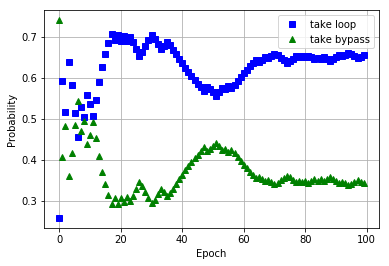

In [46]:
plt.plot(M, 'bs', label='take loop')
plt.plot(1-M, 'g^', label='take bypass')
plt.xlabel('Epoch')
plt.ylabel('Probability')
plt.grid(True)
plt.legend()
plt.show()